In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
from natsort import natsorted
from os import listdir
from scipy import sparse
from tqdm import tqdm
import math
import random
import numpy as np
import gc
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy 

In [3]:
class scDataset(Dataset):
 
    def __init__(self,scanpyX):
        self.df=scanpyX
 
        x=self.df.iloc[:,:].values
        y=np.zeros(self.df.shape[0])
 
        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx], self.y_train[idx]

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, act = True):
        super(MLP, self).__init__()
        self.act_flag = act
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        self.act = nn.ReLU()
        
    def forward(self, pre_layer):
        x = self.linear(pre_layer)
        if self.act_flag:
            x = self.act(x)
        return x

In [5]:
class scAE(nn.Module):
    def __init__(self, encoder_nhiddens, decoder_nhiddens, act = True, device = "cuda:0"):
        super(scAE, self).__init__()
        
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        self.en_l = len(encoder_nhiddens)
        self.de_l = len(decoder_nhiddens)
        self.act = act
        
        for i in range(self.en_l-2):
            self.encoder.add_module("encoder_layer" + str(i), 
                                    MLP(encoder_nhiddens[i], encoder_nhiddens[i+1], self.act))
            
        self.encoder.add_module("encoder_layer" + str(self.en_l-1), 
                                MLP(encoder_nhiddens[self.en_l-2], encoder_nhiddens[self.en_l-1], act=False))
        
        for i in range(self.de_l-2):
            self.decoder.add_module("decoder_layer" + str(i),
                                    MLP(decoder_nhiddens[i], decoder_nhiddens[i+1], self.act))
            
        self.decoder.add_module("decoder_layer" + str(self.de_l-1), 
                                MLP(decoder_nhiddens[self.de_l-2], decoder_nhiddens[self.de_l-1], act=True))
            
    def forward(self, x):        
        for i in range(self.en_l-1):
            x = self.encoder[i](x)
            
        for i in range(self.en_l-1):
            x = self.decoder[i](x)
            
        return x

In [6]:
store_path = "scDDPM_model.pt"

In [7]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data_path = '/Shang_PHD/TrainingData/V1/HumanCellAtlas/'
        self.data = []
        for npz in natsorted(listdir(self.data_path)):
            self.data.append(self.data_path + npz)
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, sample):
        cell = np.load(self.data[sample])
        row = cell['row']
        col = cell['col']
        dat = cell['data']
        #coo = sparse.coo_matrix((dat, (row, col)), shape=(1, self.data['shape'][1]))
        idx = torch.tensor(np.array([row, col]))
        value = torch.tensor(dat, dtype=torch.float32)
        data_tensor = torch.sparse_coo_tensor(idx, value, (1, 17430))
        data_tensor = data_tensor.to_dense()
        data_tensor = data_tensor.squeeze()
        return data_tensor

In [8]:
dataset = CustomDataset()

In [9]:
dataset.__len__()

599926

In [10]:
599126*0.9

539213.4

In [29]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [599926-55000, 5000, 50000])

In [75]:
val_loader=DataLoader(val_set, batch_size=5000, shuffle=False)

In [76]:
val_data = next(iter(val_loader))

In [12]:
test_loader=DataLoader(test_set, batch_size=50000, shuffle=False)
test_data = next(iter(test_loader))
TestData = test_data.to("cuda:0")

In [77]:
valData = val_data.to("cuda:0")

In [16]:
train_loader=DataLoader(train_set, batch_size=128, shuffle=True)

In [17]:
len(train_loader.dataset)

544926

In [18]:
model = scAE((train_set.__getitem__(0).shape[0], 2048, 1024, 512, 256), (256, 512, 1024, 2048, train_set.__getitem__(0).shape[0])).to("cuda:0")

In [19]:
optimer = torch.optim.Adam(model.parameters(),
                             lr = 0.0002)#,
                             #weight_decay = 1e-8)

/home/sgao30/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
mse = nn.MSELoss()
best_loss = float("inf")
all_losses = []
val_losses = []
n_epochs = 1000
device = "cuda:0"
#valData = val_data.to("cuda:0")
for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="red"):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(train_loader, leave = False, desc=f"Epoch {epoch + 1}/{n_epochs}",  mininterval = 30, colour="black")):
        x_in = batch[0].to(device)
        n = len(x_in)
        x_out = model(x_in) 
        loss = mse(x_in, x_out)
        optimer.zero_grad()
        loss.backward()
        optimer.step()
            
        epoch_loss += loss.item()# * len(x_in) / len(train_loader.dataset)
        #print(f"Loss: {epoch_loss:.3f}")
    
    val_recon = model(valData)
    val_loss = mse(valData, val_recon).item()
    all_losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    log_string1 = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    log_string2 = f"Loss at epoch {epoch + 1}: {val_loss:.3f}"
    
    if best_loss > val_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), store_path)
        log_string2 += " --> Best model ever (stroed)"
    else:
        log_string2 += "   No better than best."

    print(log_string1)
    print(log_string2)

Training progress:   0%|                  | 1/1000 [06:23<106:28:01, 383.66s/it]

Loss at epoch 1: 2653.235
Loss at epoch 1: 0.619 --> Best model ever (stroed)



Training progress:   0%|                   | 2/1000 [11:15<91:19:47, 329.45s/it]

Loss at epoch 2: 2600.716
Loss at epoch 2: 0.610 --> Best model ever (stroed)



Training progress:   0%|                   | 3/1000 [16:06<86:22:42, 311.90s/it]

Loss at epoch 3: 2575.569
Loss at epoch 3: 0.608 --> Best model ever (stroed)



Training progress:   0%|                   | 4/1000 [20:58<84:10:51, 304.27s/it]

Loss at epoch 4: 2577.192
Loss at epoch 4: 0.604 --> Best model ever (stroed)



Training progress:   0%|                   | 5/1000 [25:51<82:54:22, 299.96s/it]

Loss at epoch 5: 2556.912
Loss at epoch 5: 0.601 --> Best model ever (stroed)



Training progress:   1%|                   | 6/1000 [30:43<82:07:08, 297.41s/it]

Loss at epoch 6: 2546.561
Loss at epoch 6: 0.600 --> Best model ever (stroed)



Training progress:   1%|▏                  | 7/1000 [35:31<81:08:46, 294.19s/it]

Loss at epoch 7: 2548.539
Loss at epoch 7: 0.599 --> Best model ever (stroed)



Training progress:   1%|▏                  | 8/1000 [40:23<80:54:31, 293.62s/it]

Loss at epoch 8: 2561.381
Loss at epoch 8: 0.598 --> Best model ever (stroed)



Training progress:   1%|▏                  | 9/1000 [45:16<80:48:48, 293.57s/it]

Loss at epoch 9: 2538.355
Loss at epoch 9: 0.596 --> Best model ever (stroed)



Training progress:   1%|▏                 | 10/1000 [50:08<80:32:33, 292.88s/it]

Loss at epoch 10: 2537.095
Loss at epoch 10: 0.595 --> Best model ever (stroed)



Training progress:   1%|▏                 | 11/1000 [55:02<80:31:55, 293.14s/it]

Loss at epoch 11: 2528.521
Loss at epoch 11: 0.593 --> Best model ever (stroed)



Training progress:   1%|▏                 | 12/1000 [59:54<80:22:06, 292.84s/it]

Loss at epoch 12: 2528.755
Loss at epoch 12: 0.593 --> Best model ever (stroed)



Training progress:   1%|▏               | 13/1000 [1:04:45<80:09:59, 292.40s/it]

Loss at epoch 13: 2511.879
Loss at epoch 13: 0.592 --> Best model ever (stroed)



Training progress:   1%|▏               | 14/1000 [1:09:38<80:09:29, 292.67s/it]

Loss at epoch 14: 2510.630
Loss at epoch 14: 0.591 --> Best model ever (stroed)



Training progress:   2%|▏               | 15/1000 [1:14:31<80:04:49, 292.68s/it]

Loss at epoch 15: 2507.751
Loss at epoch 15: 0.589 --> Best model ever (stroed)



Training progress:   2%|▎               | 16/1000 [1:19:24<80:00:37, 292.72s/it]

Loss at epoch 16: 2486.062
Loss at epoch 16: 0.588 --> Best model ever (stroed)



Training progress:   2%|▎               | 17/1000 [1:24:15<79:46:39, 292.17s/it]

Loss at epoch 17: 2506.289
Loss at epoch 17: 0.587 --> Best model ever (stroed)



Training progress:   2%|▎               | 18/1000 [1:29:05<79:34:41, 291.73s/it]

Loss at epoch 18: 2513.947
Loss at epoch 18: 0.586 --> Best model ever (stroed)



Training progress:   2%|▎               | 19/1000 [1:33:59<79:37:25, 292.20s/it]

Loss at epoch 19: 2500.937
Loss at epoch 19: 0.586 --> Best model ever (stroed)



Training progress:   2%|▎               | 20/1000 [1:38:44<78:57:43, 290.06s/it]

Loss at epoch 20: 2500.511
Loss at epoch 20: 0.584 --> Best model ever (stroed)



Training progress:   2%|▎               | 21/1000 [1:43:37<79:08:35, 291.03s/it]

Loss at epoch 21: 2498.840
Loss at epoch 21: 0.584 --> Best model ever (stroed)



Training progress:   2%|▎               | 22/1000 [1:48:28<79:03:45, 291.03s/it]

Loss at epoch 22: 2479.596
Loss at epoch 22: 0.584 --> Best model ever (stroed)



Training progress:   2%|▎               | 23/1000 [1:53:21<79:07:22, 291.55s/it]

Loss at epoch 23: 2485.846
Loss at epoch 23: 0.583 --> Best model ever (stroed)



Training progress:   2%|▍               | 24/1000 [1:58:13<79:05:26, 291.73s/it]

Loss at epoch 24: 2477.676
Loss at epoch 24: 0.583 --> Best model ever (stroed)



Training progress:   2%|▍               | 25/1000 [2:03:05<79:00:04, 291.70s/it]

Loss at epoch 25: 2484.987
Loss at epoch 25: 0.582 --> Best model ever (stroed)



Training progress:   3%|▍               | 26/1000 [2:07:57<78:58:33, 291.90s/it]

Loss at epoch 26: 2469.530
Loss at epoch 26: 0.582 --> Best model ever (stroed)



Training progress:   3%|▍               | 27/1000 [2:12:43<78:25:14, 290.15s/it]

Loss at epoch 27: 2475.049
Loss at epoch 27: 0.582 --> Best model ever (stroed)



Training progress:   3%|▍               | 28/1000 [2:17:29<78:00:29, 288.92s/it]

Loss at epoch 28: 2470.739
Loss at epoch 28: 0.581 --> Best model ever (stroed)



Training progress:   3%|▍               | 29/1000 [2:22:14<77:37:21, 287.79s/it]

Loss at epoch 29: 2461.198
Loss at epoch 29: 0.581   No better than best.



Training progress:   3%|▍               | 30/1000 [2:27:05<77:45:55, 288.61s/it]

Loss at epoch 30: 2467.810
Loss at epoch 30: 0.580 --> Best model ever (stroed)



Training progress:   3%|▍               | 31/1000 [2:31:58<78:00:47, 289.83s/it]

Loss at epoch 31: 2463.458
Loss at epoch 31: 0.580 --> Best model ever (stroed)



Training progress:   3%|▌               | 32/1000 [2:36:49<78:05:59, 290.45s/it]

Loss at epoch 32: 2477.390
Loss at epoch 32: 0.580 --> Best model ever (stroed)



Training progress:   3%|▌               | 33/1000 [2:41:37<77:48:30, 289.67s/it]

Loss at epoch 33: 2470.033
Loss at epoch 33: 0.580 --> Best model ever (stroed)



Training progress:   3%|▌               | 34/1000 [2:46:24<77:27:44, 288.68s/it]

Loss at epoch 34: 2472.877
Loss at epoch 34: 0.579 --> Best model ever (stroed)



Training progress:   4%|▌               | 35/1000 [2:51:17<77:43:32, 289.96s/it]

Loss at epoch 35: 2472.149
Loss at epoch 35: 0.579   No better than best.



Training progress:   4%|▌               | 36/1000 [2:56:08<77:47:45, 290.52s/it]

Loss at epoch 36: 2471.027
Loss at epoch 36: 0.578 --> Best model ever (stroed)



Training progress:   4%|▌               | 37/1000 [3:00:59<77:43:13, 290.54s/it]

Loss at epoch 37: 2453.351
Loss at epoch 37: 0.579   No better than best.



Training progress:   4%|▌               | 38/1000 [3:05:50<77:39:22, 290.61s/it]

Loss at epoch 38: 2460.626
Loss at epoch 38: 0.578 --> Best model ever (stroed)



Training progress:   4%|▌               | 39/1000 [3:10:40<77:32:19, 290.47s/it]

Loss at epoch 39: 2458.502
Loss at epoch 39: 0.578   No better than best.



Training progress:   4%|▋               | 40/1000 [3:15:31<77:32:20, 290.77s/it]

Loss at epoch 40: 2470.313
Loss at epoch 40: 0.578 --> Best model ever (stroed)



Training progress:   4%|▋               | 41/1000 [3:20:24<77:34:21, 291.20s/it]

Loss at epoch 41: 2446.521
Loss at epoch 41: 0.578 --> Best model ever (stroed)



Training progress:   4%|▋               | 42/1000 [3:25:12<77:14:10, 290.24s/it]

Loss at epoch 42: 2465.335
Loss at epoch 42: 0.578 --> Best model ever (stroed)



Training progress:   4%|▋               | 43/1000 [3:29:58<76:48:57, 288.96s/it]

Loss at epoch 43: 2464.962
Loss at epoch 43: 0.578 --> Best model ever (stroed)



Training progress:   4%|▋               | 44/1000 [3:34:45<76:38:38, 288.62s/it]

Loss at epoch 44: 2436.414
Loss at epoch 44: 0.578 --> Best model ever (stroed)



Training progress:   4%|▋               | 45/1000 [3:39:29<76:10:39, 287.16s/it]

Loss at epoch 45: 2451.461
Loss at epoch 45: 0.578 --> Best model ever (stroed)



Training progress:   5%|▋               | 46/1000 [3:44:15<76:01:06, 286.86s/it]

Loss at epoch 46: 2461.150
Loss at epoch 46: 0.578 --> Best model ever (stroed)



Training progress:   5%|▊               | 47/1000 [3:49:05<76:09:06, 287.67s/it]

Loss at epoch 47: 2449.994
Loss at epoch 47: 0.577 --> Best model ever (stroed)



Training progress:   5%|▊               | 48/1000 [3:53:57<76:23:42, 288.89s/it]

Loss at epoch 48: 2443.549
Loss at epoch 48: 0.577 --> Best model ever (stroed)



Training progress:   5%|▊               | 49/1000 [3:58:48<76:30:13, 289.60s/it]

Loss at epoch 49: 2434.073
Loss at epoch 49: 0.577 --> Best model ever (stroed)



Training progress:   5%|▊               | 50/1000 [4:03:40<76:36:39, 290.31s/it]

Loss at epoch 50: 2454.121
Loss at epoch 50: 0.577 --> Best model ever (stroed)



Training progress:   5%|▊               | 51/1000 [4:08:32<76:41:14, 290.91s/it]

Loss at epoch 51: 2444.625
Loss at epoch 51: 0.578   No better than best.



Training progress:   5%|▊               | 52/1000 [4:13:24<76:41:38, 291.24s/it]

Loss at epoch 52: 2459.809
Loss at epoch 52: 0.577   No better than best.



Training progress:   5%|▊               | 53/1000 [4:18:16<76:41:44, 291.56s/it]

Loss at epoch 53: 2439.301
Loss at epoch 53: 0.577 --> Best model ever (stroed)



Training progress:   5%|▊               | 54/1000 [4:23:09<76:43:35, 291.98s/it]

Loss at epoch 54: 2456.208
Loss at epoch 54: 0.577 --> Best model ever (stroed)



Training progress:   6%|▉               | 55/1000 [4:28:03<76:43:52, 292.31s/it]

Loss at epoch 55: 2445.449
Loss at epoch 55: 0.577 --> Best model ever (stroed)



Training progress:   6%|▉               | 56/1000 [4:32:56<76:45:37, 292.73s/it]

Loss at epoch 56: 2467.982
Loss at epoch 56: 0.577 --> Best model ever (stroed)



Training progress:   6%|▉               | 57/1000 [4:37:50<76:44:05, 292.94s/it]

Loss at epoch 57: 2459.166
Loss at epoch 57: 0.577 --> Best model ever (stroed)



Training progress:   6%|▉               | 58/1000 [4:42:43<76:40:12, 293.01s/it]

Loss at epoch 58: 2459.691
Loss at epoch 58: 0.577   No better than best.



Training progress:   6%|▉               | 59/1000 [4:47:34<76:25:24, 292.37s/it]

Loss at epoch 59: 2443.455
Loss at epoch 59: 0.577   No better than best.



Training progress:   6%|▉               | 60/1000 [4:52:27<76:24:16, 292.61s/it]

Loss at epoch 60: 2450.430
Loss at epoch 60: 0.577 --> Best model ever (stroed)



Training progress:   6%|▉               | 61/1000 [4:57:19<76:17:44, 292.51s/it]

Loss at epoch 61: 2452.417
Loss at epoch 61: 0.576 --> Best model ever (stroed)



Training progress:   6%|▉               | 62/1000 [5:02:10<76:03:40, 291.92s/it]

Loss at epoch 62: 2447.750
Loss at epoch 62: 0.577   No better than best.



Training progress:   6%|█               | 63/1000 [5:06:58<75:39:51, 290.71s/it]

Loss at epoch 63: 2441.637
Loss at epoch 63: 0.577   No better than best.



Training progress:   6%|█               | 64/1000 [5:11:44<75:17:05, 289.56s/it]

Loss at epoch 64: 2465.729
Loss at epoch 64: 0.576 --> Best model ever (stroed)



Training progress:   6%|█               | 65/1000 [5:16:30<74:55:45, 288.50s/it]

Loss at epoch 65: 2453.114
Loss at epoch 65: 0.576   No better than best.



Training progress:   7%|█               | 66/1000 [5:21:21<74:59:44, 289.06s/it]

Loss at epoch 66: 2454.568
Loss at epoch 66: 0.576   No better than best.



Training progress:   7%|█               | 67/1000 [5:26:12<75:05:42, 289.76s/it]

Loss at epoch 67: 2461.526
Loss at epoch 67: 0.576   No better than best.



Training progress:   7%|█               | 68/1000 [5:31:03<75:06:49, 290.14s/it]

Loss at epoch 68: 2455.187
Loss at epoch 68: 0.577   No better than best.



Training progress:   7%|█               | 69/1000 [5:35:55<75:11:06, 290.73s/it]

Loss at epoch 69: 2447.267
Loss at epoch 69: 0.576 --> Best model ever (stroed)



Training progress:   7%|█               | 70/1000 [5:40:47<75:08:19, 290.86s/it]

Loss at epoch 70: 2445.248
Loss at epoch 70: 0.576   No better than best.



Training progress:   7%|█▏              | 71/1000 [5:45:39<75:10:28, 291.31s/it]

Loss at epoch 71: 2462.384
Loss at epoch 71: 0.576 --> Best model ever (stroed)



Training progress:   7%|█▏              | 72/1000 [5:50:31<75:09:30, 291.56s/it]

Loss at epoch 72: 2443.357
Loss at epoch 72: 0.576 --> Best model ever (stroed)



Training progress:   7%|█▏              | 73/1000 [5:55:23<75:05:11, 291.60s/it]

Loss at epoch 73: 2439.294
Loss at epoch 73: 0.576   No better than best.



Training progress:   7%|█▏              | 74/1000 [6:00:14<74:58:02, 291.45s/it]

Loss at epoch 74: 2454.559
Loss at epoch 74: 0.576   No better than best.



Training progress:   8%|█▏              | 75/1000 [6:05:03<74:43:34, 290.83s/it]

Loss at epoch 75: 2461.563
Loss at epoch 75: 0.576   No better than best.



Training progress:   8%|█▏              | 76/1000 [6:09:49<74:15:04, 289.29s/it]

Loss at epoch 76: 2442.230
Loss at epoch 76: 0.576 --> Best model ever (stroed)



Training progress:   8%|█▏              | 77/1000 [6:14:34<73:49:50, 287.96s/it]

Loss at epoch 77: 2440.759
Loss at epoch 77: 0.576   No better than best.



Training progress:   8%|█▏              | 78/1000 [6:19:23<73:50:13, 288.30s/it]

Loss at epoch 78: 2449.850
Loss at epoch 78: 0.576   No better than best.



Training progress:   8%|█▎              | 79/1000 [6:24:11<73:43:05, 288.15s/it]

Loss at epoch 79: 2440.796
Loss at epoch 79: 0.576   No better than best.



Training progress:   8%|█▎              | 80/1000 [6:29:02<73:52:56, 289.10s/it]

Loss at epoch 80: 2453.203
Loss at epoch 80: 0.576   No better than best.



Training progress:   8%|█▎              | 81/1000 [6:33:52<73:52:37, 289.40s/it]

Loss at epoch 81: 2452.074
Loss at epoch 81: 0.576   No better than best.



Training progress:   8%|█▎              | 82/1000 [6:38:39<73:36:52, 288.69s/it]

Loss at epoch 82: 2446.139
Loss at epoch 82: 0.576   No better than best.



Training progress:   8%|█▎              | 83/1000 [6:43:29<73:38:16, 289.09s/it]

Loss at epoch 83: 2451.798
Loss at epoch 83: 0.577   No better than best.



Training progress:   8%|█▎              | 84/1000 [6:48:13<73:10:17, 287.57s/it]

Loss at epoch 84: 2448.386
Loss at epoch 84: 0.576 --> Best model ever (stroed)



Training progress:   8%|█▎              | 85/1000 [6:52:58<72:54:21, 286.84s/it]

Loss at epoch 85: 2438.055
Loss at epoch 85: 0.576   No better than best.



Training progress:   9%|█▍              | 86/1000 [6:57:48<73:03:31, 287.76s/it]

Loss at epoch 86: 2432.159
Loss at epoch 86: 0.576   No better than best.



Training progress:   9%|█▍              | 87/1000 [7:02:40<73:18:27, 289.06s/it]

Loss at epoch 87: 2437.180
Loss at epoch 87: 0.576   No better than best.



Training progress:   9%|█▍              | 88/1000 [7:07:32<73:28:01, 290.00s/it]

Loss at epoch 88: 2420.403
Loss at epoch 88: 0.576   No better than best.



Training progress:   9%|█▍              | 89/1000 [7:12:25<73:32:22, 290.61s/it]

Loss at epoch 89: 2457.285
Loss at epoch 89: 0.576   No better than best.



Training progress:   9%|█▍              | 90/1000 [7:17:14<73:24:07, 290.38s/it]

Loss at epoch 90: 2432.673
Loss at epoch 90: 0.576   No better than best.



Training progress:   9%|█▍              | 91/1000 [7:22:04<73:16:00, 290.17s/it]

Loss at epoch 91: 2429.457
Loss at epoch 91: 0.576   No better than best.



Training progress:   9%|█▍              | 92/1000 [7:26:55<73:15:48, 290.47s/it]

Loss at epoch 92: 2443.142
Loss at epoch 92: 0.576   No better than best.



Training progress:   9%|█▍              | 93/1000 [7:31:47<73:16:33, 290.84s/it]

Loss at epoch 93: 2460.177
Loss at epoch 93: 0.575 --> Best model ever (stroed)



Training progress:   9%|█▌              | 94/1000 [7:36:39<73:19:33, 291.36s/it]

Loss at epoch 94: 2443.384
Loss at epoch 94: 0.575 --> Best model ever (stroed)



Training progress:  10%|█▌              | 95/1000 [7:41:30<73:11:45, 291.17s/it]

Loss at epoch 95: 2428.957
Loss at epoch 95: 0.575   No better than best.



Training progress:  10%|█▌              | 96/1000 [7:46:22<73:11:09, 291.45s/it]

Loss at epoch 96: 2448.360
Loss at epoch 96: 0.575 --> Best model ever (stroed)



Training progress:  10%|█▌              | 97/1000 [7:51:14<73:06:39, 291.47s/it]

Loss at epoch 97: 2439.786
Loss at epoch 97: 0.576   No better than best.



Training progress:  10%|█▌              | 98/1000 [7:56:06<73:04:58, 291.68s/it]

Loss at epoch 98: 2459.332
Loss at epoch 98: 0.575 --> Best model ever (stroed)



Training progress:  10%|█▌              | 99/1000 [8:00:58<73:02:56, 291.87s/it]

Loss at epoch 99: 2466.689
Loss at epoch 99: 0.575 --> Best model ever (stroed)



Training progress:  10%|█▌             | 100/1000 [8:05:49<72:54:40, 291.65s/it]

Loss at epoch 100: 2445.091
Loss at epoch 100: 0.575   No better than best.



Training progress:  10%|█▌             | 101/1000 [8:10:42<72:54:30, 291.96s/it]

Loss at epoch 101: 2441.691
Loss at epoch 101: 0.576   No better than best.



Training progress:  10%|█▌             | 102/1000 [8:15:32<72:40:47, 291.37s/it]

Loss at epoch 102: 2434.451
Loss at epoch 102: 0.575   No better than best.



Training progress:  10%|█▌             | 103/1000 [8:20:23<72:33:40, 291.22s/it]

Loss at epoch 103: 2410.061
Loss at epoch 103: 0.575   No better than best.



Training progress:  10%|█▌             | 104/1000 [8:25:15<72:33:58, 291.56s/it]

Loss at epoch 104: 2449.291
Loss at epoch 104: 0.575   No better than best.



Training progress:  10%|█▌             | 105/1000 [8:30:09<72:36:51, 292.08s/it]

Loss at epoch 105: 2457.662
Loss at epoch 105: 0.575 --> Best model ever (stroed)



Training progress:  11%|█▌             | 106/1000 [8:35:02<72:36:17, 292.37s/it]

Loss at epoch 106: 2432.053
Loss at epoch 106: 0.576   No better than best.



Training progress:  11%|█▌             | 107/1000 [8:39:54<72:33:00, 292.48s/it]

Loss at epoch 107: 2443.545
Loss at epoch 107: 0.575   No better than best.



Training progress:  11%|█▌             | 108/1000 [8:44:48<72:33:17, 292.82s/it]

Loss at epoch 108: 2444.693
Loss at epoch 108: 0.575   No better than best.



Training progress:  11%|█▋             | 109/1000 [8:49:40<72:22:38, 292.43s/it]

Loss at epoch 109: 2440.888
Loss at epoch 109: 0.575   No better than best.



Training progress:  11%|█▋             | 110/1000 [8:54:31<72:14:39, 292.22s/it]

Loss at epoch 110: 2434.690
Loss at epoch 110: 0.576   No better than best.



Training progress:  11%|█▋             | 111/1000 [8:59:25<72:14:21, 292.53s/it]

Loss at epoch 111: 2455.820
Loss at epoch 111: 0.575 --> Best model ever (stroed)



Training progress:  11%|█▋             | 112/1000 [9:04:17<72:08:54, 292.49s/it]

Loss at epoch 112: 2445.162
Loss at epoch 112: 0.575   No better than best.



Training progress:  11%|█▋             | 113/1000 [9:09:09<72:02:38, 292.40s/it]

Loss at epoch 113: 2432.917
Loss at epoch 113: 0.575 --> Best model ever (stroed)



Training progress:  11%|█▋             | 114/1000 [9:14:02<71:58:16, 292.43s/it]

Loss at epoch 114: 2428.211
Loss at epoch 114: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▋             | 115/1000 [9:18:55<71:56:42, 292.66s/it]

Loss at epoch 115: 2439.414
Loss at epoch 115: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▋             | 116/1000 [9:23:47<71:50:49, 292.59s/it]

Loss at epoch 116: 2436.968
Loss at epoch 116: 0.574   No better than best.



Training progress:  12%|█▊             | 117/1000 [9:28:39<71:43:00, 292.39s/it]

Loss at epoch 117: 2446.224
Loss at epoch 117: 0.574   No better than best.



Training progress:  12%|█▊             | 118/1000 [9:33:31<71:34:38, 292.15s/it]

Loss at epoch 118: 2437.877
Loss at epoch 118: 0.574   No better than best.



Training progress:  12%|█▊             | 119/1000 [9:38:26<71:45:24, 293.22s/it]

Loss at epoch 119: 2436.088
Loss at epoch 119: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▊             | 120/1000 [9:43:19<71:37:11, 292.99s/it]

Loss at epoch 120: 2451.920
Loss at epoch 120: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▊             | 121/1000 [9:48:11<71:29:40, 292.81s/it]

Loss at epoch 121: 2446.334
Loss at epoch 121: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▊             | 122/1000 [9:53:04<71:23:08, 292.70s/it]

Loss at epoch 122: 2432.847
Loss at epoch 122: 0.574   No better than best.



Training progress:  12%|█▊             | 123/1000 [9:57:55<71:11:25, 292.23s/it]

Loss at epoch 123: 2440.651
Loss at epoch 123: 0.574   No better than best.



Training progress:  12%|█▋            | 124/1000 [10:02:47<71:06:15, 292.21s/it]

Loss at epoch 124: 2444.693
Loss at epoch 124: 0.574 --> Best model ever (stroed)



Training progress:  12%|█▊            | 125/1000 [10:07:39<70:59:49, 292.10s/it]

Loss at epoch 125: 2443.176
Loss at epoch 125: 0.574   No better than best.



Training progress:  13%|█▊            | 126/1000 [10:12:32<70:58:54, 292.37s/it]

Loss at epoch 126: 2449.675
Loss at epoch 126: 0.574   No better than best.



Training progress:  13%|█▊            | 127/1000 [10:17:23<70:49:33, 292.07s/it]

Loss at epoch 127: 2440.319
Loss at epoch 127: 0.574   No better than best.



Training progress:  13%|█▊            | 128/1000 [10:22:15<70:44:02, 292.02s/it]

Loss at epoch 128: 2432.479
Loss at epoch 128: 0.574 --> Best model ever (stroed)



Training progress:  13%|█▊            | 129/1000 [10:27:07<70:39:55, 292.07s/it]

Loss at epoch 129: 2451.376
Loss at epoch 129: 0.574   No better than best.



Training progress:  13%|█▊            | 130/1000 [10:32:00<70:38:02, 292.28s/it]

Loss at epoch 130: 2435.631
Loss at epoch 130: 0.574   No better than best.



Training progress:  13%|█▊            | 131/1000 [10:36:49<70:19:32, 291.34s/it]

Loss at epoch 131: 2438.376
Loss at epoch 131: 0.574 --> Best model ever (stroed)



Training progress:  13%|█▊            | 132/1000 [10:41:35<69:52:01, 289.77s/it]

Loss at epoch 132: 2436.855
Loss at epoch 132: 0.574   No better than best.



Training progress:  13%|█▊            | 133/1000 [10:46:25<69:47:10, 289.77s/it]

Loss at epoch 133: 2440.280
Loss at epoch 133: 0.574 --> Best model ever (stroed)



Training progress:  13%|█▉            | 134/1000 [10:51:16<69:46:06, 290.03s/it]

Loss at epoch 134: 2430.687
Loss at epoch 134: 0.574   No better than best.



Training progress:  14%|█▉            | 135/1000 [10:56:07<69:47:12, 290.44s/it]

Loss at epoch 135: 2438.718
Loss at epoch 135: 0.574   No better than best.



Training progress:  14%|█▉            | 136/1000 [11:00:59<69:46:29, 290.73s/it]

Loss at epoch 136: 2462.895
Loss at epoch 136: 0.574   No better than best.



Training progress:  14%|█▉            | 137/1000 [11:05:50<69:43:46, 290.88s/it]

Loss at epoch 137: 2437.116
Loss at epoch 137: 0.574   No better than best.



Training progress:  14%|█▉            | 138/1000 [11:10:39<69:33:02, 290.47s/it]

Loss at epoch 138: 2451.599
Loss at epoch 138: 0.574   No better than best.



Training progress:  14%|█▉            | 139/1000 [11:15:22<68:53:12, 288.03s/it]

Loss at epoch 139: 2439.995
Loss at epoch 139: 0.574   No better than best.



Training progress:  14%|█▉            | 140/1000 [11:20:12<68:58:51, 288.76s/it]

Loss at epoch 140: 2441.309
Loss at epoch 140: 0.574 --> Best model ever (stroed)



Training progress:  14%|█▉            | 141/1000 [11:25:06<69:14:21, 290.18s/it]

Loss at epoch 141: 2435.182
Loss at epoch 141: 0.574 --> Best model ever (stroed)



Training progress:  14%|█▉            | 142/1000 [11:29:58<69:19:02, 290.84s/it]

Loss at epoch 142: 2431.354
Loss at epoch 142: 0.574   No better than best.



Training progress:  14%|██            | 143/1000 [11:34:50<69:20:09, 291.26s/it]

Loss at epoch 143: 2448.811
Loss at epoch 143: 0.574   No better than best.



Training progress:  14%|██            | 144/1000 [11:39:44<69:25:08, 291.95s/it]

Loss at epoch 144: 2436.705
Loss at epoch 144: 0.574   No better than best.



Training progress:  14%|██            | 145/1000 [11:44:37<69:24:26, 292.24s/it]

Loss at epoch 145: 2450.027
Loss at epoch 145: 0.574   No better than best.



Training progress:  15%|██            | 146/1000 [11:49:29<69:17:52, 292.12s/it]

Loss at epoch 146: 2439.102
Loss at epoch 146: 0.574   No better than best.



Training progress:  15%|██            | 147/1000 [11:54:22<69:17:05, 292.41s/it]

Loss at epoch 147: 2443.462
Loss at epoch 147: 0.574 --> Best model ever (stroed)



Training progress:  15%|██            | 148/1000 [11:59:14<69:13:08, 292.47s/it]

Loss at epoch 148: 2435.825
Loss at epoch 148: 0.574   No better than best.



Training progress:  15%|██            | 149/1000 [12:04:07<69:08:45, 292.51s/it]

Loss at epoch 149: 2431.993
Loss at epoch 149: 0.574   No better than best.



Training progress:  15%|██            | 150/1000 [12:09:00<69:06:49, 292.72s/it]

Loss at epoch 150: 2446.407
Loss at epoch 150: 0.574 --> Best model ever (stroed)



Training progress:  15%|██            | 151/1000 [12:13:53<69:02:11, 292.73s/it]

Loss at epoch 151: 2428.118
Loss at epoch 151: 0.574   No better than best.



Training progress:  15%|██▏           | 152/1000 [12:18:44<68:50:09, 292.23s/it]

Loss at epoch 152: 2456.173
Loss at epoch 152: 0.574   No better than best.



Training progress:  15%|██▏           | 153/1000 [12:23:36<68:44:48, 292.19s/it]

Loss at epoch 153: 2432.392
Loss at epoch 153: 0.574   No better than best.



Training progress:  15%|██▏           | 154/1000 [12:28:30<68:45:45, 292.61s/it]

Loss at epoch 154: 2436.321
Loss at epoch 154: 0.574   No better than best.



Training progress:  16%|██▏           | 155/1000 [12:33:21<68:37:09, 292.34s/it]

Loss at epoch 155: 2424.908
Loss at epoch 155: 0.574   No better than best.



Training progress:  16%|██▏           | 156/1000 [12:38:14<68:32:08, 292.33s/it]

Loss at epoch 156: 2441.427
Loss at epoch 156: 0.574 --> Best model ever (stroed)



Training progress:  16%|██▏           | 157/1000 [12:43:03<68:15:27, 291.49s/it]

Loss at epoch 157: 2430.225
Loss at epoch 157: 0.574   No better than best.



Training progress:  16%|██▏           | 158/1000 [12:47:55<68:10:53, 291.51s/it]

Loss at epoch 158: 2432.606
Loss at epoch 158: 0.574   No better than best.



Training progress:  16%|██▏           | 159/1000 [12:52:46<68:06:53, 291.57s/it]

Loss at epoch 159: 2431.592
Loss at epoch 159: 0.574   No better than best.



Training progress:  16%|██▏           | 160/1000 [12:57:39<68:07:05, 291.93s/it]

Loss at epoch 160: 2433.621
Loss at epoch 160: 0.574   No better than best.



Training progress:  16%|██▎           | 161/1000 [13:02:28<67:49:27, 291.02s/it]

Loss at epoch 161: 2439.397
Loss at epoch 161: 0.574   No better than best.



Training progress:  16%|██▎           | 162/1000 [13:07:18<67:38:07, 290.56s/it]

Loss at epoch 162: 2435.100
Loss at epoch 162: 0.574   No better than best.



Training progress:  16%|██▎           | 163/1000 [13:12:09<67:37:55, 290.89s/it]

Loss at epoch 163: 2423.311
Loss at epoch 163: 0.574   No better than best.



Training progress:  16%|██▎           | 164/1000 [13:16:58<67:23:05, 290.17s/it]

Loss at epoch 164: 2433.709
Loss at epoch 164: 0.574   No better than best.



Training progress:  16%|██▎           | 165/1000 [13:21:45<67:06:45, 289.35s/it]

Loss at epoch 165: 2454.965
Loss at epoch 165: 0.574 --> Best model ever (stroed)



Training progress:  17%|██▎           | 166/1000 [13:26:31<66:46:56, 288.27s/it]

Loss at epoch 166: 2429.376
Loss at epoch 166: 0.574   No better than best.



Training progress:  17%|██▎           | 167/1000 [13:31:23<66:57:52, 289.40s/it]

Loss at epoch 167: 2434.984
Loss at epoch 167: 0.574   No better than best.



Training progress:  17%|██▎           | 168/1000 [13:36:12<66:52:19, 289.35s/it]

Loss at epoch 168: 2429.153
Loss at epoch 168: 0.574   No better than best.



Training progress:  17%|██▎           | 169/1000 [13:40:58<66:34:46, 288.43s/it]

Loss at epoch 169: 2439.173
Loss at epoch 169: 0.574 --> Best model ever (stroed)



Training progress:  17%|██▍           | 170/1000 [13:45:46<66:27:28, 288.25s/it]

Loss at epoch 170: 2434.198
Loss at epoch 170: 0.574   No better than best.



Training progress:  17%|██▍           | 171/1000 [13:50:38<66:36:18, 289.24s/it]

Loss at epoch 171: 2422.108
Loss at epoch 171: 0.574   No better than best.



Training progress:  17%|██▍           | 172/1000 [13:55:29<66:38:00, 289.71s/it]

Loss at epoch 172: 2432.282
Loss at epoch 172: 0.574   No better than best.



Training progress:  17%|██▍           | 173/1000 [14:00:20<66:38:48, 290.12s/it]

Loss at epoch 173: 2431.527
Loss at epoch 173: 0.574   No better than best.



Training progress:  17%|██▍           | 174/1000 [14:05:12<66:41:05, 290.64s/it]

Loss at epoch 174: 2439.665
Loss at epoch 174: 0.574   No better than best.



Training progress:  18%|██▍           | 175/1000 [14:10:04<66:43:36, 291.17s/it]

Loss at epoch 175: 2434.575
Loss at epoch 175: 0.573 --> Best model ever (stroed)



Training progress:  18%|██▍           | 176/1000 [14:14:55<66:39:53, 291.25s/it]

Loss at epoch 176: 2439.772
Loss at epoch 176: 0.574   No better than best.



Training progress:  18%|██▍           | 177/1000 [14:19:45<66:30:00, 290.89s/it]

Loss at epoch 177: 2446.599
Loss at epoch 177: 0.574   No better than best.



Training progress:  18%|██▍           | 178/1000 [14:24:37<66:29:42, 291.22s/it]

Loss at epoch 178: 2449.303
Loss at epoch 178: 0.574   No better than best.



Training progress:  18%|██▌           | 179/1000 [14:29:30<66:32:12, 291.76s/it]

Loss at epoch 179: 2429.221
Loss at epoch 179: 0.574   No better than best.



Training progress:  18%|██▌           | 180/1000 [14:34:22<66:25:06, 291.59s/it]

Loss at epoch 180: 2447.238
Loss at epoch 180: 0.574   No better than best.



Training progress:  18%|██▌           | 181/1000 [14:39:08<65:59:07, 290.05s/it]

Loss at epoch 181: 2418.270
Loss at epoch 181: 0.574   No better than best.



Training progress:  18%|██▌           | 182/1000 [14:44:00<66:00:24, 290.49s/it]

Loss at epoch 182: 2433.594
Loss at epoch 182: 0.574   No better than best.



Training progress:  18%|██▌           | 183/1000 [14:48:52<66:03:05, 291.05s/it]

Loss at epoch 183: 2432.677
Loss at epoch 183: 0.573   No better than best.



Training progress:  18%|██▌           | 184/1000 [14:53:44<66:01:05, 291.26s/it]

Loss at epoch 184: 2439.216
Loss at epoch 184: 0.574   No better than best.



Training progress:  18%|██▌           | 185/1000 [14:58:35<65:56:41, 291.29s/it]

Loss at epoch 185: 2453.812
Loss at epoch 185: 0.574   No better than best.



Training progress:  19%|██▌           | 186/1000 [15:03:27<65:55:32, 291.56s/it]

Loss at epoch 186: 2440.567
Loss at epoch 186: 0.574   No better than best.



Training progress:  19%|██▌           | 187/1000 [15:08:19<65:52:29, 291.70s/it]

Loss at epoch 187: 2425.617
Loss at epoch 187: 0.574   No better than best.



Training progress:  19%|██▋           | 188/1000 [15:13:11<65:49:12, 291.81s/it]

Loss at epoch 188: 2426.116
Loss at epoch 188: 0.574   No better than best.



Training progress:  19%|██▋           | 189/1000 [15:18:04<65:46:21, 291.96s/it]

Loss at epoch 189: 2449.278
Loss at epoch 189: 0.574   No better than best.



Training progress:  19%|██▋           | 190/1000 [15:22:55<65:39:07, 291.79s/it]

Loss at epoch 190: 2438.710
Loss at epoch 190: 0.574   No better than best.



Training progress:  19%|██▋           | 191/1000 [15:27:48<65:40:17, 292.23s/it]

Loss at epoch 191: 2418.213
Loss at epoch 191: 0.574   No better than best.



Training progress:  19%|██▋           | 192/1000 [15:32:41<65:38:17, 292.45s/it]

Loss at epoch 192: 2447.107
Loss at epoch 192: 0.574   No better than best.



Training progress:  19%|██▋           | 193/1000 [15:37:34<65:34:41, 292.54s/it]

Loss at epoch 193: 2450.335
Loss at epoch 193: 0.574   No better than best.



Training progress:  19%|██▋           | 194/1000 [15:42:27<65:32:15, 292.72s/it]

Loss at epoch 194: 2439.249
Loss at epoch 194: 0.574   No better than best.



Training progress:  20%|██▋           | 195/1000 [15:47:21<65:29:49, 292.91s/it]

Loss at epoch 195: 2434.388
Loss at epoch 195: 0.574   No better than best.



Training progress:  20%|██▋           | 196/1000 [15:52:14<65:26:40, 293.04s/it]

Loss at epoch 196: 2438.247
Loss at epoch 196: 0.573 --> Best model ever (stroed)



Training progress:  20%|██▋           | 196/1000 [15:53:10<65:09:56, 291.79s/it]


KeyboardInterrupt: 

In [21]:
val_recon

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward0>)

In [23]:
val_loss

0.5733453631401062

In [17]:
#training_loop(model, train_loader, n_epochs=100, optim=optimer, device="cuda:0")

In [13]:
best_model = scAE((train_set.__getitem__(0).shape[0], 2048, 1024, 512, 256), (256, 512, 1024, 2048, train_set.__getitem__(0).shape[0])).to("cuda:0")
best_model.load_state_dict(torch.load(store_path))
#best_model.eval()

<All keys matched successfully>

In [15]:
TestData.shape

torch.Size([50000, 17430])

In [16]:
recons = best_model(TestData)

In [17]:
recons.shape

torch.Size([50000, 17430])

In [18]:
latent_ae = best_model.encoder(TestData)

In [19]:
latent_ae.shape

torch.Size([50000, 256])

In [35]:
real_and_recon = np.concatenate((recons.cpu().detach().numpy(), TestData.cpu().detach().numpy()), 0)

In [36]:
real_and_recon.shape

(100000, 17430)

In [21]:
#latent_ae = best_model.encoder(ds.x_train.to("cuda:0"))

In [22]:
#latent_ae.shape

torch.Size([31489, 200])

In [21]:
import umap

/home/sgao30/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
reducer = umap.UMAP()

In [24]:
embedding = reducer.fit_transform(latent_ae.cpu().detach().numpy())

In [103]:
embedding_real = reducer.fit_transform(valData.cpu().detach().numpy())

In [104]:
embedding_recon = reducer.fit_transform(recons.cpu().detach().numpy())

In [37]:
#embedding_real_and_recon = reducer.fit_transform(real_and_recon.cpu().detach().numpy())
embedding_real_and_recon = reducer.fit_transform(real_and_recon)

In [38]:
cell_info = pd.read_csv('/Shang_PHD/processed_data/DataSets_Part11/cell_info_table.csv')

In [39]:
val_set_info = cell_info.iloc[test_set.indices]

In [40]:
newMetaData = val_set_info['tissue'].tolist()

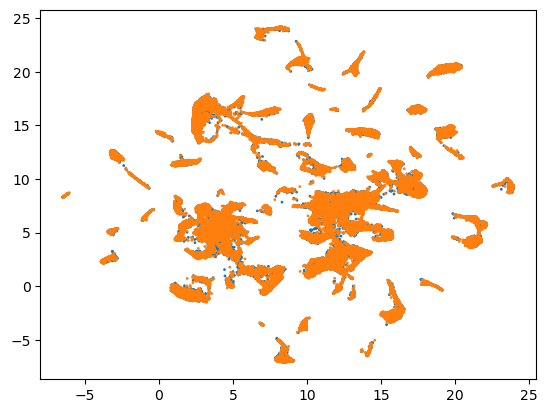

In [41]:
import matplotlib.pyplot as plt
import matplotlib
cellType = np.array(["Recons", "Real"])
newMetaData =  np.repeat(cellType, [50000, 50000], axis=0)
levels, categories = pd.factorize(newMetaData)
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
plt.scatter(embedding_real_and_recon[:, 0], embedding_real_and_recon[:, 1], s=1, c=colors)

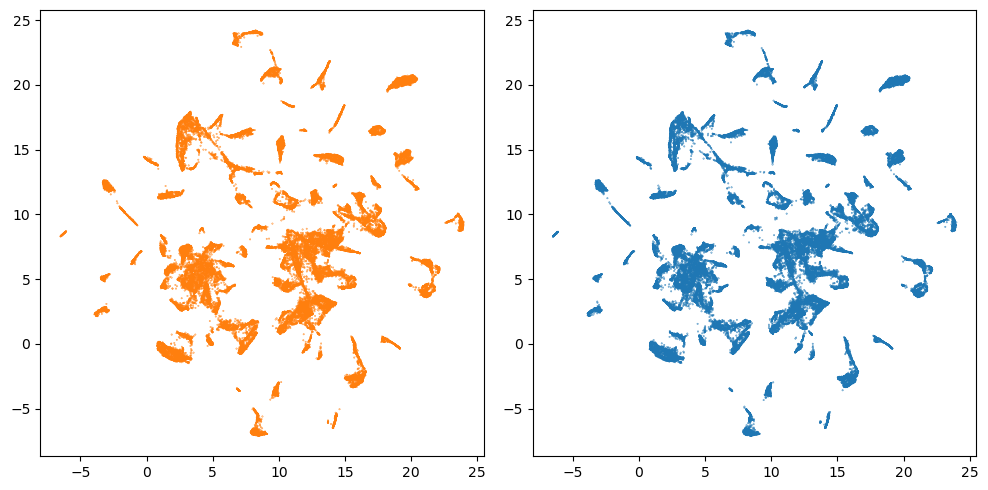

In [43]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1, 2, 1)
plt.scatter(embedding_real_and_recon[:, 0], embedding_real_and_recon[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([0, 1]), [50000, 50000], axis=0))
fig.add_subplot(1, 2, 2)
plt.scatter(embedding_real_and_recon[:, 0], embedding_real_and_recon[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([1, 0]), [50000, 50000], axis=0))
fig.tight_layout()

/tmp/ipykernel_11531/162845426.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  levels, categories = pd.factorize(newMetaData)


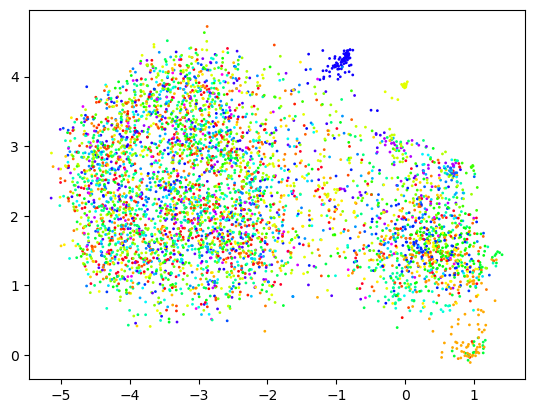

In [105]:
import matplotlib.pyplot as plt
import matplotlib
levels, categories = pd.factorize(newMetaData)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/len(categories)) for i in levels]
plt.scatter(embedding_real[:, 0], embedding_real[:, 1], s=1, c=colors)

/tmp/ipykernel_11531/3411732098.py:1: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  levels, categories = pd.factorize(newMetaData)


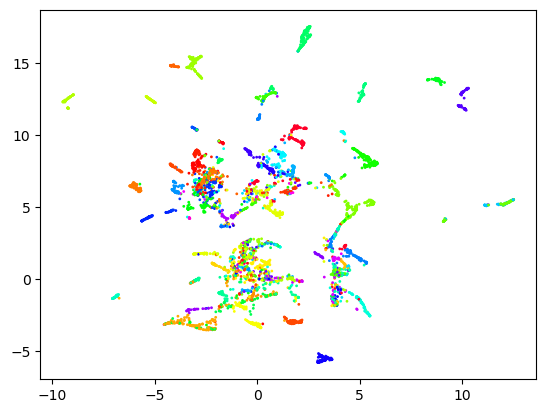

In [106]:
levels, categories = pd.factorize(newMetaData)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/len(categories)) for i in levels]
plt.scatter(embedding_recon[:, 0], embedding_recon[:, 1], s=1, c=colors)

/tmp/ipykernel_4616/2892283095.py:3: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  levels, categories = pd.factorize(newMetaData)


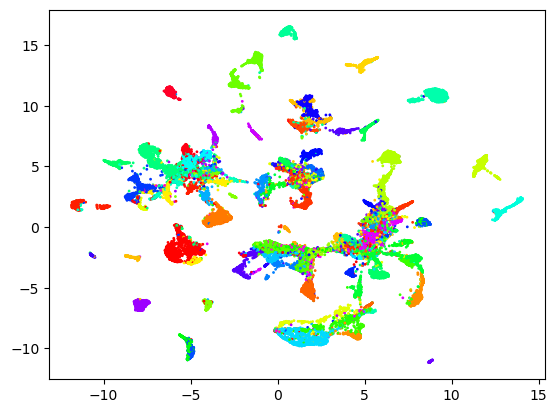

In [33]:
import matplotlib.pyplot as plt
import matplotlib
levels, categories = pd.factorize(newMetaData)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/len(categories)) for i in levels]
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, c=colors)

In [11]:
dataloader=DataLoader(dataset, batch_size=1, shuffle=False)

In [12]:
best_model = scAE((dataset.__getitem__(0).shape[0], 2048, 1024, 512, 256), (256, 512, 1024, 2048, dataset.__getitem__(0).shape[0])).to("cuda:0")
best_model.load_state_dict(torch.load(store_path))
#best_model.eval()

<All keys matched successfully>

In [36]:
device = "cuda:0"

for step, batch in enumerate(tqdm(dataloader, leave = False, desc=f"generate cells",  mininterval = 30, colour="black")):
    x_input = batch[0].to(device)
    latent_ae = best_model.encoder(x_input)
    np.save(file="../HumanCellAtlasAE256/c_"+str(step)+".npy", arr=latent_ae.cpu().detach().numpy())
        